## Exploratory Analysis

Before we create any models or draw any conclusions, we first want to understand our data. First visualizing the distribution of some of our columns will help us identify any biases or outliers in the data before using it concretely.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import wget

For our EDA we will be using a sample chunk of the data which is equivalent to about 4% of the total data. The data has already been pre-selected to contain only columns we have found interesting to perform analysis on. To give a sense of those columns here is the first entry in the dataframe.

In [2]:
voters = pd.read_csv("gs://data-download756575/data/WI_chunks/WI_datachunk0.csv/data.csv")
voters.head(1)

,LALVOTERID,Voters_Active,Voters_StateVoterID,Residence_Addresses_Latitude,Residence_Addresses_Longitude,Residence_Addresses_Property_LandSq_Footage,Residence_Families_HHCount,Residence_HHGender_Description,Residence_HHParties_Description,Voters_Gender,...,EthnicGroups_EthnicGroup1Desc,Religions_Description,MilitaryStatus_Description,Languages_Description,CommercialData_ISPSA,County,CommercialData_Education,CommercialData_EstHomeValue,CommercialData_EstimatedHHIncomeAmount,CommercialData_EstimatedAreaMedianHHIncome
0,LALWI119383427,I,702783320,44.24694,-91.49755,NaN,1,Female Only Household,Democratic,F,...,NaN,NaN,NaN,NaN,NaN,TREMPEALEAU,HS Diploma - Likely,$235888,28000.0,NaN


Certain obserations in this dataframe have addresses outside state lines. To improve the clarity of our visualizations we decided to remove these outliers for our EDA.

In [3]:
# Removes outliers that have addresses outside state lines.
query = "(Residence_Addresses_Longitude > -93 and Residence_Addresses_Longitude < -85) and (Residence_Addresses_Latitude > 42 and Residence_Addresses_Latitude < 47)"
voters = voters.query(query)

In [4]:
# Total observations in chunk dataset
len(voters)

191418

In [5]:
# Counting NaN values in all columns
nan_count = voters.isna().sum()

print(nan_count)

LALVOTERID                                          0
Voters_Active                                       0
Voters_StateVoterID                                 0
Residence_Addresses_Latitude                        0
Residence_Addresses_Longitude                       0
Residence_Addresses_Property_LandSq_Footage     49343
Residence_Families_HHCount                          0
Residence_HHGender_Description                      0
Residence_HHParties_Description                     0
Voters_Gender                                    2366
Voters_Age                                      72295
Voters_BirthDate                                72295
Parties_Description                                 0
Ethnic_Description                              28360
EthnicGroups_EthnicGroup1Desc                   28360
Religions_Description                          120754
MilitaryStatus_Description                     190742
Languages_Description                          114556
CommercialData_ISPSA        

In [8]:
voters["EthnicGroups_EthnicGroup1Desc"].unique()

array([nan, 'European', 'Hispanic and Portuguese', 'Other',
       'Likely African-American', 'East and South Asian'], dtype=object)

In [ ]:
di = {"European": "E", "Hispanic and Portuguese":"H", 'Likely African-American':"AA", 'East and South Asian':"A"}
voters["EthnicGroups_EthnicGroup1Desc"].replace(di, inplace=True)

A number of our selected columns have a large proportion of NaN values. 

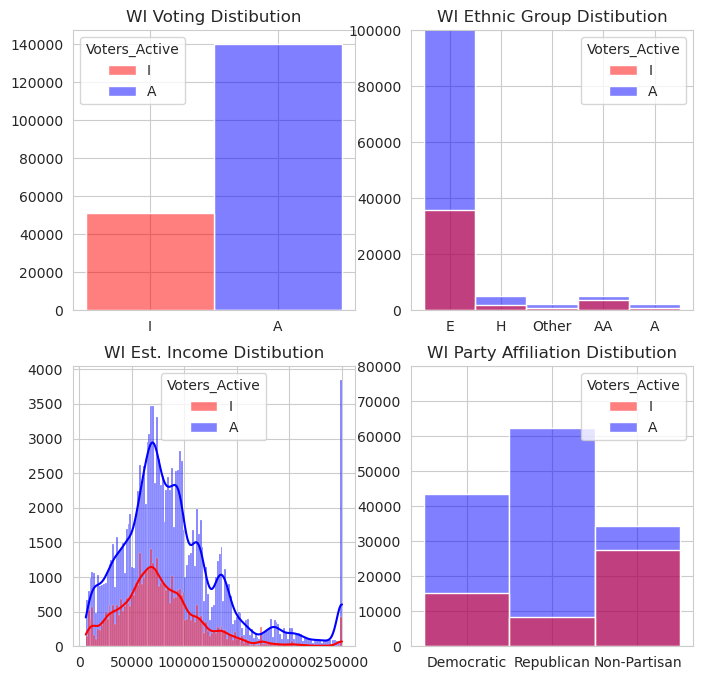

In [12]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2, 2, figsize=(8,8))
ax= ax.flatten()

sns.histplot(ax=ax[0],data=voters, x="Voters_Active", hue="Voters_Active", palette = ["red","blue"])
ax[0].set_title("WI Voting Distibution")


sns.histplot(ax=ax[1],data=voters, x="EthnicGroups_EthnicGroup1Desc",hue="Voters_Active",palette = ["red","blue"])
ax[1].set_title("WI Ethnic Group Distibution")
ax[1].set_ylim(0,100000)

sns.histplot(ax=ax[2],data=voters, x="CommercialData_EstimatedHHIncomeAmount",hue="Voters_Active",palette = ["red","blue"], kde=True)
ax[2].set_title("WI Est. Income Distibution")

sns.histplot(ax=ax[3],data=voters, x="Parties_Description",hue="Voters_Active",palette = ["red","blue"])
ax[3].set_title("WI Party Affiliation Distibution")
ax[3].set_ylim(0,80000)

for axes in ax:
    axes.set(ylabel = None,xlabel=None)

*Note: Ethnic group labels correspond to "European": "E", "Hispanic and Portuguese":"H", 'Likely African-American':"AA", 'East and South Asian':"A"*

Generally a few things seems to jump out immediately when very voter disparity among the general populace. Going in order of the plots: 

- The ratio of voters to non-voters seems to be about a 3:1 ratio, which is about the expected national average of 66% voter turnout at least for the 2020 election. 

- Ethnically Wisconsin is overwhelmingly white/European. Among ethnic groups the biggest outlier is African American populace where the majority of voting eligible citizens do not vote. 

- Somewhat surprisingly, for the general population, income does not seem to have a large effect on voters vs non-voters. Except at the very highest income levels where a disproportionally large part of the population does vote. Perhaps this will change when looking at different ethnic groups? 

- And lastly, Republican voters easily take the crown for most active voters, and unsurprisingly non-partisan voters are the biggest group of non-voters.

In [54]:
def plot_WI(counties = True, ax = None):
    # checks if ax exists and if not creates ax
    if not ax:
        fig, ax = plt.subplots(1, figsize=(8,18))
    
    if counties:
        counties = wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")
        gdf = gpd.read_file(counties)

    else:
        states = wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")
        gdf = gpd.read_file(states)
        
    WI = gdf.query("STATEFP == '55'")
    
    WI.boundary.plot(ax=ax, color="black")

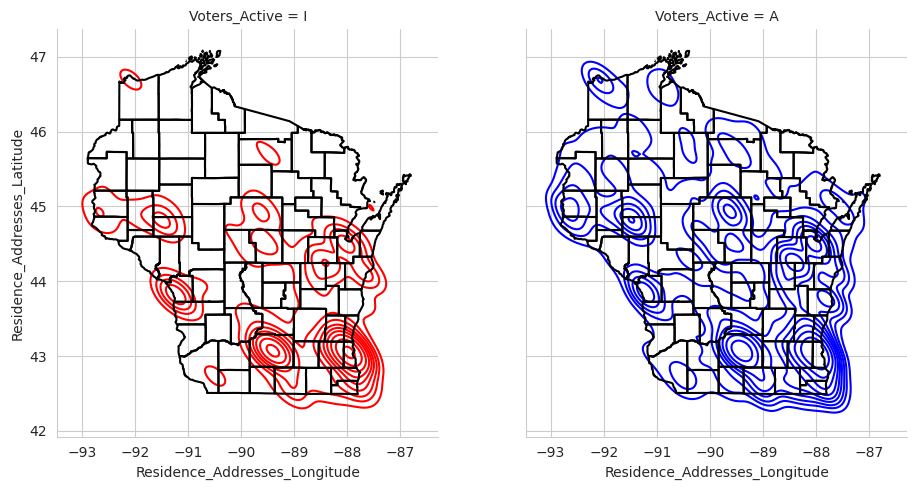

In [63]:
contour_voters =  sns.displot(data=voters,x='Residence_Addresses_Longitude',y='Residence_Addresses_Latitude', kind='kde', legend = False, col = "Voters_Active", hue  = "Voters_Active",palette = ["red","blue"], col_wrap = 2)
for ax in contour_voters.axes.flat:
    ax = plot_WI(ax=ax)


Mapping voters vs. non-voters does not seem to reveal too much valuable information.
- Most voters and non-voters are unsurprisingly located at high-density population centers. 

- Notably, the population of rural areas, seems to have little to no non-voters.

0it [33:41, ?it/s]


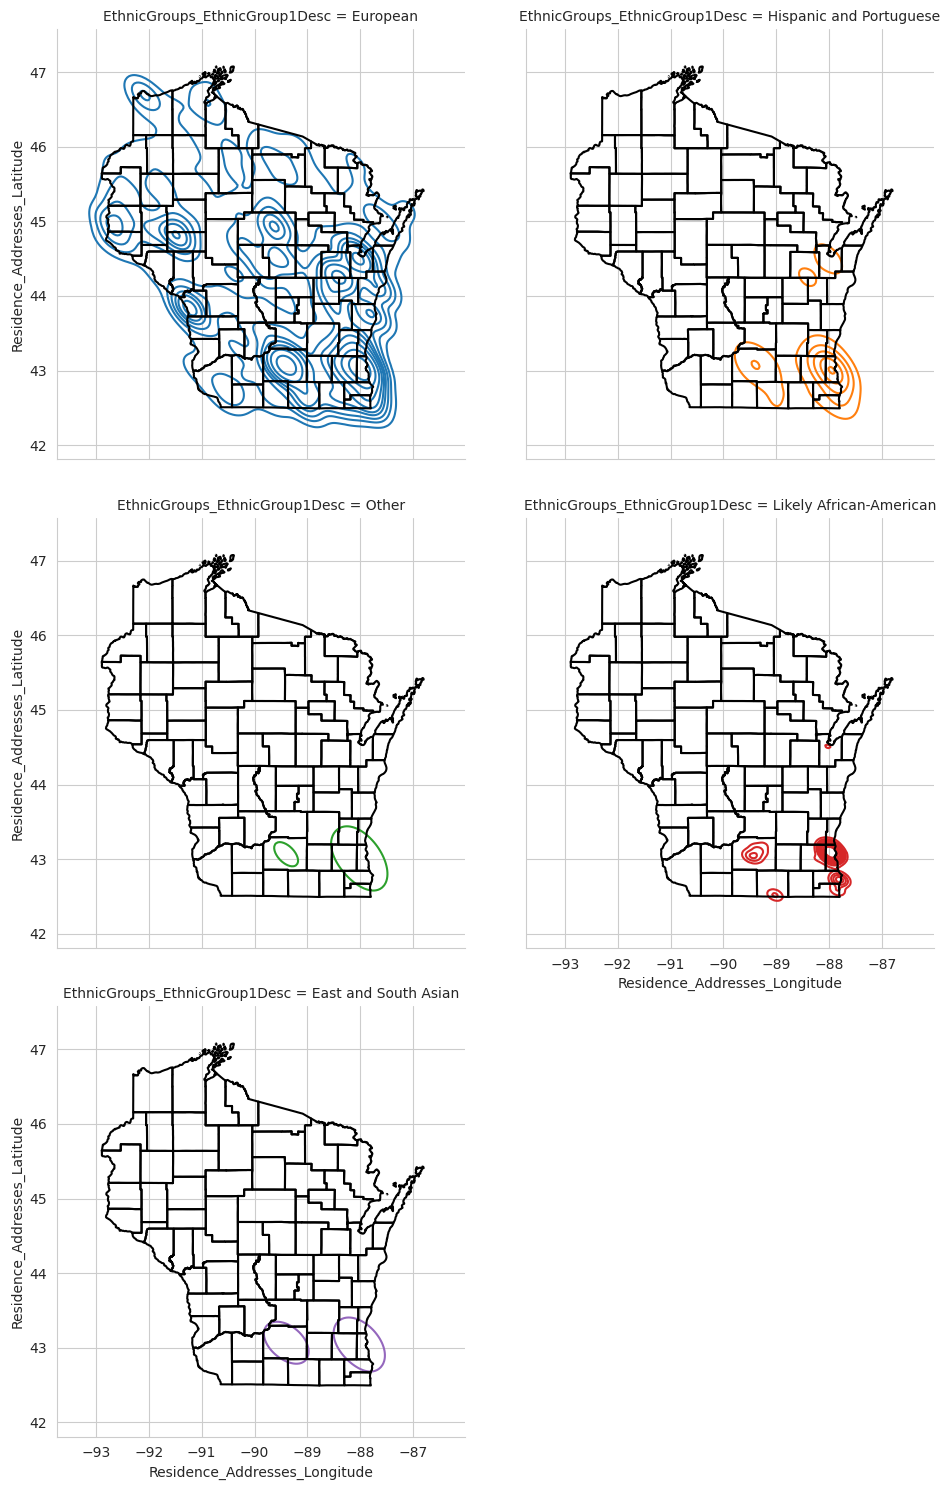

In [65]:
contour_voters =  sns.displot(data=voters,x='Residence_Addresses_Longitude',y='Residence_Addresses_Latitude', kind='kde', legend = False, col = "EthnicGroups_EthnicGroup1Desc", hue  = "EthnicGroups_EthnicGroup1Desc",palette = "tab10", col_wrap = 2)
for ax in contour_voters.axes.flat:
    ax = plot_WI(ax=ax)

Slowly the picture is getting somewhat clearer, the vast majority of the African American population, which we already know to be more inclined to not vote, live in Milwaukee and Racine counties. And looking back at the location of non-voters of WI proportionally most of the live in the Milwaukee county areas.

*Picture of WI counties for reference*
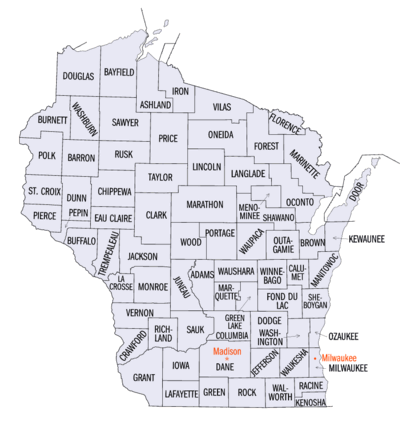

## Exploring African American voters

Much of the attention when examining voter disparity in the nation goes to African American or black voters. Blacks in American do historically have some of the lowest voter turnout rates, which unfortunately has been used in the past to critique black people as being lazy or inept. Research suggests the truth is much more complicated with a history of disenfranchisement with both main political parties and strict voting laws preventing potential black voters from casting their votes.

Our EDA has already shown disproportionally voting low rates for black people in Wisconsin. Exploring the other factors of black voters shows a few more key findings.

In [29]:
black_voters = pd.read_csv("gs://data-download756575/data/ethnic_groups/csv/aa_data.csv")
black_voters["se_ladder"].replace({"No record": np.nan}, inplace=True)
black_voters['se_ladder'] = black_voters['se_ladder'].astype(float)

/tmp/ipykernel_4478/252364402.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  black_voters = pd.read_csv("gs://data-download756575/data/ethnic_groups/csv/aa_data.csv")


In [30]:
black_voters.head(1)

,lalvoterid,voters_active,voters_statevoterid,residence_addresses_latitude,residence_addresses_longitude,voters_gender,voters_age,parties_description,militarystatus_description,se_ladder,county,commercialdata_education,commercialdata_estimatedhhincomeamount,commercialdata_estimatedareamedianhhincome,language_groups,religion_groups,property_value_per_sqft
0,LALWI121272675,I,12313413,43.841673,-88.843587,F,No record,Democratic,Not in military,NaN,FOND DU LAC,No record,No record,No record,No record,No record,NaN


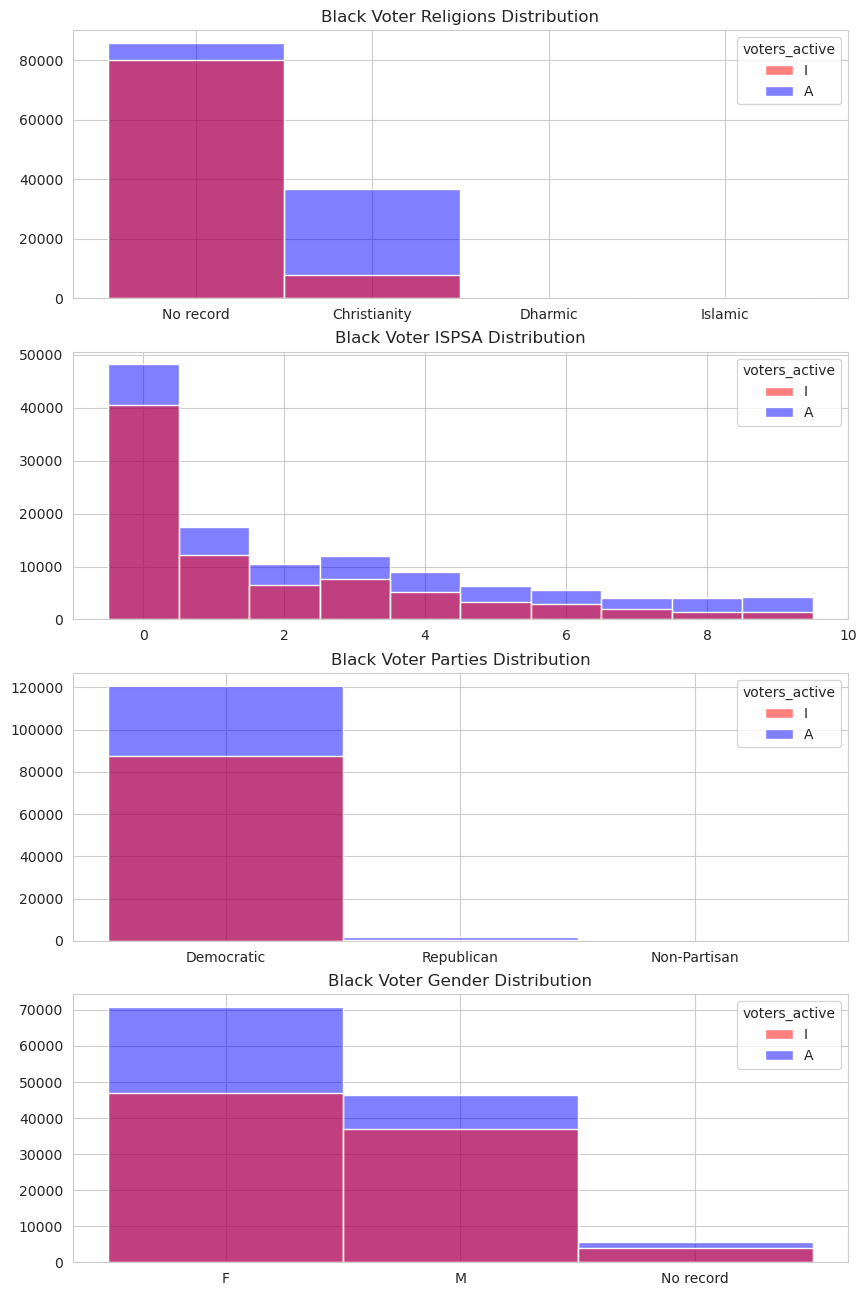

In [39]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(4, 1, figsize=(10,16))
ax= ax.flatten()

sns.histplot(ax=ax[0],data=black_voters, x="religion_groups", hue="voters_active", palette = ["red","blue"])
ax[0].set_title("Black Voter Religions Distribution")

sns.histplot(ax=ax[1],data=black_voters, x="se_ladder", hue="voters_active", palette = ["red","blue"], discrete=True)
ax[1].set_title("Black Voter ISPSA Distribution")

sns.histplot(ax=ax[2],data=black_voters, x="parties_description", hue="voters_active", palette = ["red","blue"])
ax[2].set_title("Black Voter Parties Distribution")

sns.histplot(ax=ax[3],data=black_voters, x="voters_gender", hue="voters_active", palette = ["red","blue"])
ax[3].set_title("Black Voter Gender Distribution")
for axes in ax:
    axes.set(ylabel = None,xlabel=None)

- Africa Americans who identify as Christian vote significantly more other African Americans.
- As African American voters move up the ISPSA values the voting distribution, while still somwhat low, inches towards and even past 50% as opposed to closer to 20% at the lowest level.
- Black voters almost entirely identify as Democratic, even non-Partisan isn't common surprisingly.
- Female identifying Afican Americans seems to be more active voters than men.

So our hypothesis is for black voters is the largest factors in voting participation are gender identity, religion, and ISPSA or social ladder score.